In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import itertools
import math, calendar

from torch.utils.data import DataLoader
from torch import nn
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

sys.path.append("..")
from utils import metrics
from utils.data import TimeFusionDataset
from timefusion import TimeFusion
from utils.early_stopper import EarlyStopper

In [2]:
# Import data
train_data = pd.read_csv("../../datasets/solar/train.csv", index_col="LocalTime")
val_data = pd.read_csv("../../datasets/solar/val.csv", index_col="LocalTime")
test_data = pd.read_csv("../../datasets/solar/test.csv", index_col="LocalTime")

# Normalize the signal power of each column
stds = train_data.std()
train_data /= stds
val_data /= stds
test_data /= stds

In [3]:
# Compute device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [4]:
context_length = 48
prediction_length = 24

def get_data_loader(data, context_length):

    dataset = TimeFusionDataset(
        data = data,
        context_length = context_length,
    )
    dataset.add_timestamp_encodings(
        timestamp_encodings = [
            lambda x: math.sin(2*math.pi*x.hour / 24),
            lambda x: math.sin(2*math.pi*x.weekday() / 7),
            lambda x: math.sin(2*math.pi*x.day / calendar.monthrange(x.year, x.month)[1]),
            lambda x: math.cos(2*math.pi*x.hour / 24),
            lambda x: math.cos(2*math.pi*x.weekday() / 7),
            lambda x: math.cos(2*math.pi*x.day / calendar.monthrange(x.year, x.month)[1]),
        ]
    )

    dataloader = DataLoader(
        dataset = dataset,
        shuffle = True,
        num_workers = 4,
        batch_size = 128,
    )

    return dataloader, dataset

train_loader, train_dataset = get_data_loader(train_data, context_length)
val_loader, val_dataset = get_data_loader(val_data, context_length)
test_loader, test_dataset = get_data_loader(test_data, context_length)

In [5]:
predictor = TimeFusion(
    input_size = train_dataset.data.shape[1],
    output_size = train_data.shape[1],
    rnn_layers = 2,
    rnn_hidden = 50,
    residual_layers = 2,
    residual_hidden = 50,
    scaling = True,
    device = device
)

print("Number of trainable parameters:",sum(p.numel() for p in predictor.parameters()))

Number of trainable parameters: 162386


/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timefusion/examples/../utils/diffusion.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bar_alphas = torch.tensor(


In [6]:
optimizer = torch.optim.Adam(params=predictor.parameters(),lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=100)

predictor.train_network(
    train_loader = train_loader,
    epochs=200,
    val_loader = val_loader,
    val_metrics= {
        "Val MAE": nn.L1Loss(),
    },
    optimizer = optimizer,
    lr_scheduler= lr_scheduler,
    early_stopper=EarlyStopper(patience=20),
    save_weights = True,
    weight_folder = "weights/solar"
)

Epoch: 1/40: 100%|██████████| 55/55 [00:05<00:00, 10.15batch/s, Training loss=0.8547]


Val MAE: 0.6641 , val_loss: 0.7006 , 


Epoch: 2/40: 100%|██████████| 55/55 [00:05<00:00, 10.29batch/s, Training loss=0.5984]


Val MAE: 0.5785 , val_loss: 0.5407 , 


Epoch: 3/40: 100%|██████████| 55/55 [00:05<00:00, 10.28batch/s, Training loss=0.4611]


Val MAE: 0.5068 , val_loss: 0.4274 , 


Epoch: 4/40: 100%|██████████| 55/55 [00:05<00:00, 10.87batch/s, Training loss=0.3734]


Val MAE: 0.4556 , val_loss: 0.3596 , 


Epoch: 5/40: 100%|██████████| 55/55 [00:07<00:00,  7.36batch/s, Training loss=0.3087]


Val MAE: 0.4111 , val_loss: 0.3041 , 


Epoch: 6/40: 100%|██████████| 55/55 [00:05<00:00, 10.57batch/s, Training loss=0.2734]


Val MAE: 0.3815 , val_loss: 0.2749 , 


Epoch: 7/40: 100%|██████████| 55/55 [00:05<00:00, 10.95batch/s, Training loss=0.2439]


Val MAE: 0.3597 , val_loss: 0.2536 , 


Epoch: 8/40: 100%|██████████| 55/55 [00:05<00:00, 10.82batch/s, Training loss=0.2386]


Val MAE: 0.3596 , val_loss: 0.2586 , 


Epoch: 9/40: 100%|██████████| 55/55 [00:05<00:00, 10.00batch/s, Training loss=0.2313]


Val MAE: 0.3444 , val_loss: 0.2380 , 


Epoch: 10/40: 100%|██████████| 55/55 [00:05<00:00, 10.95batch/s, Training loss=0.2300]


Val MAE: 0.3503 , val_loss: 0.2528 , 


Epoch: 11/40: 100%|██████████| 55/55 [00:05<00:00, 10.87batch/s, Training loss=0.2272]


Val MAE: 0.3467 , val_loss: 0.2443 , 


Epoch: 12/40: 100%|██████████| 55/55 [00:05<00:00, 10.51batch/s, Training loss=0.2261]


Val MAE: 0.3453 , val_loss: 0.2446 , 


Epoch: 13/40: 100%|██████████| 55/55 [00:05<00:00, 10.24batch/s, Training loss=0.2235]


Val MAE: 0.3415 , val_loss: 0.2371 , 


Epoch: 14/40: 100%|██████████| 55/55 [00:05<00:00, 10.98batch/s, Training loss=0.2163]


Val MAE: 0.3420 , val_loss: 0.2479 , 


Epoch: 15/40: 100%|██████████| 55/55 [00:05<00:00, 10.80batch/s, Training loss=0.2166]


Val MAE: 0.3460 , val_loss: 0.2495 , 


Epoch: 16/40: 100%|██████████| 55/55 [00:05<00:00, 10.92batch/s, Training loss=0.2163]


Val MAE: 0.3254 , val_loss: 0.2214 , 


Epoch: 17/40: 100%|██████████| 55/55 [00:05<00:00, 10.84batch/s, Training loss=0.2123]


Val MAE: 0.3372 , val_loss: 0.2386 , 


Epoch: 18/40: 100%|██████████| 55/55 [00:05<00:00, 10.61batch/s, Training loss=0.2125]


Val MAE: 0.3380 , val_loss: 0.2417 , 


Epoch: 19/40: 100%|██████████| 55/55 [00:05<00:00, 10.82batch/s, Training loss=0.2075]


Val MAE: 0.3366 , val_loss: 0.2377 , 


Epoch: 20/40: 100%|██████████| 55/55 [00:05<00:00, 10.08batch/s, Training loss=0.2134]


Val MAE: 0.3371 , val_loss: 0.2419 , 


Epoch: 21/40: 100%|██████████| 55/55 [00:05<00:00, 10.13batch/s, Training loss=0.2066]


Val MAE: 0.3327 , val_loss: 0.2358 , 


Epoch: 22/40: 100%|██████████| 55/55 [00:05<00:00, 10.37batch/s, Training loss=0.2058]


Val MAE: 0.3275 , val_loss: 0.2294 , 


Epoch: 23/40: 100%|██████████| 55/55 [00:05<00:00, 10.85batch/s, Training loss=0.2107]


Val MAE: 0.3254 , val_loss: 0.2245 , 


Epoch: 24/40: 100%|██████████| 55/55 [00:05<00:00, 10.17batch/s, Training loss=0.2098]


Val MAE: 0.3147 , val_loss: 0.2127 , 


Epoch: 25/40: 100%|██████████| 55/55 [00:05<00:00, 10.07batch/s, Training loss=0.2039]


Val MAE: 0.3256 , val_loss: 0.2288 , 


Epoch: 26/40: 100%|██████████| 55/55 [00:05<00:00, 10.75batch/s, Training loss=0.2061]


Val MAE: 0.3239 , val_loss: 0.2279 , 


Epoch: 27/40: 100%|██████████| 55/55 [00:05<00:00, 10.42batch/s, Training loss=0.2052]


Val MAE: 0.3241 , val_loss: 0.2273 , 


Epoch: 28/40: 100%|██████████| 55/55 [00:05<00:00, 10.35batch/s, Training loss=0.2037]


Val MAE: 0.3056 , val_loss: 0.1967 , 


Epoch: 29/40: 100%|██████████| 55/55 [00:05<00:00, 10.46batch/s, Training loss=0.1987]


Val MAE: 0.3180 , val_loss: 0.2138 , 


Epoch: 30/40: 100%|██████████| 55/55 [00:05<00:00, 10.38batch/s, Training loss=0.2050]


Val MAE: 0.3242 , val_loss: 0.2230 , 


Epoch: 31/40: 100%|██████████| 55/55 [00:05<00:00,  9.85batch/s, Training loss=0.2017]


Val MAE: 0.3219 , val_loss: 0.2261 , 


Epoch: 32/40: 100%|██████████| 55/55 [00:05<00:00, 10.25batch/s, Training loss=0.2026]


Val MAE: 0.3222 , val_loss: 0.2224 , 


Epoch: 33/40: 100%|██████████| 55/55 [00:05<00:00, 10.54batch/s, Training loss=0.1890]


Val MAE: 0.3198 , val_loss: 0.2203 , 


Epoch: 34/40: 100%|██████████| 55/55 [00:05<00:00, 10.47batch/s, Training loss=0.1986]


Val MAE: 0.3206 , val_loss: 0.2238 , 


Epoch: 35/40: 100%|██████████| 55/55 [00:05<00:00, 10.77batch/s, Training loss=0.2008]


Val MAE: 0.3085 , val_loss: 0.2036 , 


Epoch: 36/40: 100%|██████████| 55/55 [00:05<00:00, 10.81batch/s, Training loss=0.1953]


Val MAE: 0.3022 , val_loss: 0.1922 , 


Epoch: 37/40: 100%|██████████| 55/55 [00:05<00:00, 10.87batch/s, Training loss=0.1954]


Val MAE: 0.3067 , val_loss: 0.2032 , 


Epoch: 38/40: 100%|██████████| 55/55 [00:05<00:00, 10.90batch/s, Training loss=0.1988]


Val MAE: 0.3060 , val_loss: 0.2061 , 


Epoch: 39/40: 100%|██████████| 55/55 [00:05<00:00, 10.62batch/s, Training loss=0.1964]


Val MAE: 0.3118 , val_loss: 0.2089 , 


Epoch: 40/40: 100%|██████████| 55/55 [00:05<00:00, 10.40batch/s, Training loss=0.1961]


Val MAE: 0.3022 , val_loss: 0.1971 , 


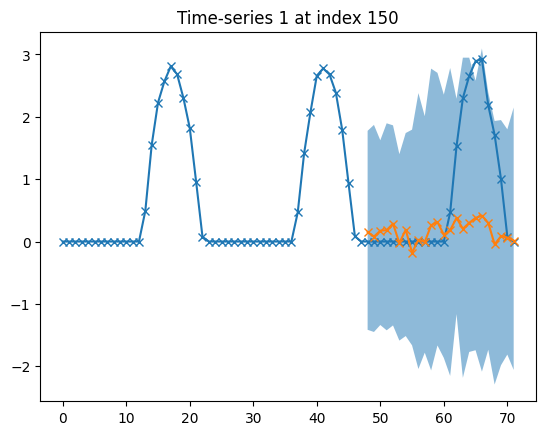

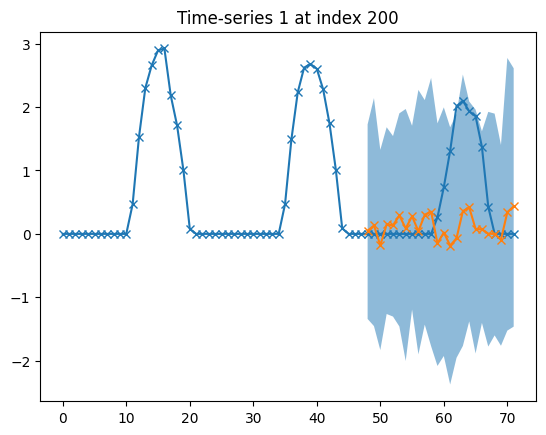

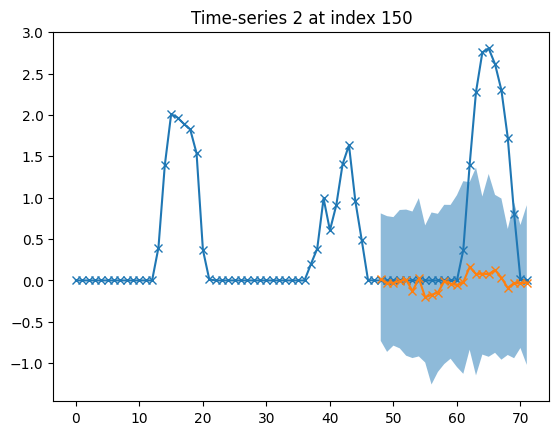

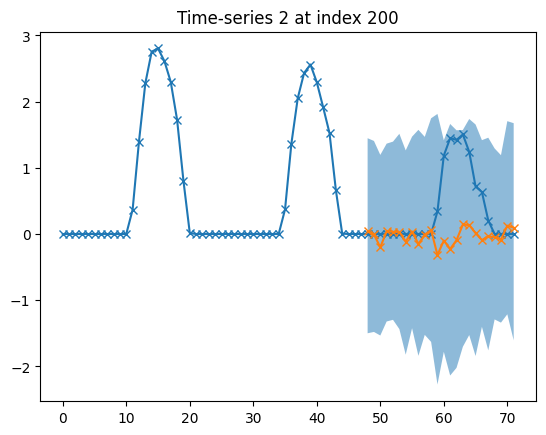

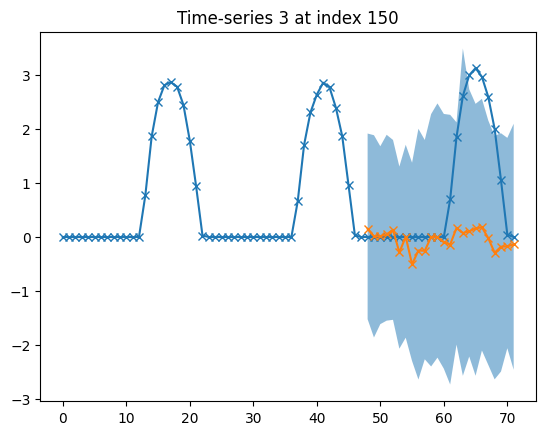

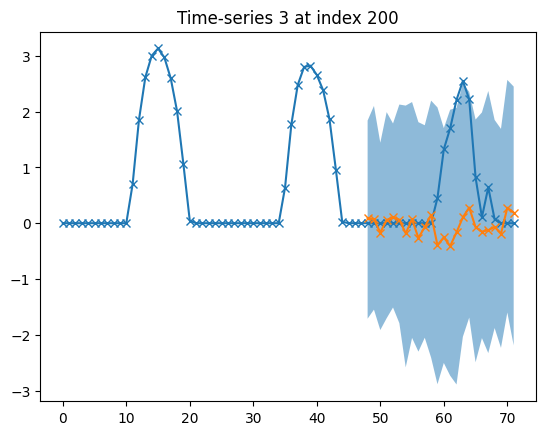

In [7]:
# Sample from model
indices = [150,200]

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
)
samples = samples.cpu()

# Sort samples in ascending order
samples = samples.permute(0,2,3,1).flatten(start_dim=0,end_dim=2).sort()[0].reshape(samples.shape[0],samples.shape[2],samples.shape[3],-1).permute(0,3,1,2)

# Plot some predictions
confidence = 0.9
for ts, i in itertools.product([1,2,3],range(len(indices))):
    plt.figure()
    plt.title(f"Time-series {ts} at index {indices[i]}")
    plt.plot(test_dataset.tensor_data[indices[i]:indices[i]+context_length+prediction_length,ts],"-x")
    plt.plot(list(range(context_length,context_length+prediction_length)),torch.mean(samples[i,:,ts],dim = 0),"-x")
    plt.fill_between(list(range(context_length,context_length+prediction_length)), samples[i,int(confidence*samples.shape[1]),ts], samples[i,int((1-confidence)*samples.shape[1]),ts],alpha=0.5)

In [12]:
# Make samples and extract realisations for last 14 months of test dataset
last_idx = test_dataset.tensor_data.shape[0] - prediction_length - context_length
indices = list(range(last_idx, last_idx - prediction_length*14, -prediction_length))

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
)

realisations = []
for idx in indices:
    realisations.append(
        test_dataset.tensor_data[context_length + idx:context_length + idx + prediction_length, test_dataset.pred_columns].T
    )
realisations = torch.stack(realisations).to(samples.device)


In [13]:
# Calculate metrics
mean_predictions = samples.mean(axis=1)

# MSE, MAE, MDAE
mse = mean_squared_error(realisations.flatten(), mean_predictions.flatten())
mae = mean_absolute_error(realisations.flatten(), mean_predictions.flatten())
mdae = median_absolute_error(realisations.flatten(), mean_predictions.flatten())
print("MSE:", mse, "MAE:", mae, "MDAE:", mdae)

# CRPS_sum and Variogram_score
crps_sum = np.mean([metrics.crps_sum(samples[i], realisations[i]) for i in range(realisations.shape[0])])
variogram_score = np.mean([metrics.variogram_score(samples[i], realisations[i], weights="local", window_size=3) for i in range(realisations.shape[0])])
print("CRPS_sum:", crps_sum, "Variogram_score:", variogram_score)

MSE: 0.61065835 MAE: 0.39721206 MDAE: 0.08259012
CRPS_sum: 51.379569899468194 Variogram_score: 0.3521912515917349
